In [1]:
# imports
import numpy as np
import random
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

# loading data
iris = datasets.load_iris()
X = iris.data[:, [0,2]]
y = iris.target

# converts a list of 2/3-valued integer labels to color markers for plotting purposes
def giveColor(label):
    if label == 0:
        return 'r'
    elif label == 1:
        return 'b'
    return 'g'

# creates a simple scatter plot using 2D data and labels
def twoDimScatterPlot(X, y):
    cols = []
    for label in y:
        cols.append(giveColor(label))
    plt.scatter(X[:,0], X[:,1], color=cols)

# 1. Bootstrap sampling

Study the function below. It is an implementation of the bootstrap sampling procedure. By drawing a random index from the range of the original data, and adding the value and label at that index to a new set, we guarantee sampling with replacement, because the original data stays intact. In the implementation below, samples are drawn until the sample set is equal to the original set in size.

In [2]:
# creates a bootstrapped sample from an input dataset of the same size
def bootstrapSample(data, labels):
    bootstrappedData = []
    bootstrappedLabels = []
    for i in range(len(data)):
        x = random.randint(0, len(data) - 1) 
        bootstrappedData.append(data[x])
        bootstrappedLabels.append(labels[x])
    return np.array(bootstrappedData), np.array(bootstrappedLabels)

## 1. 2 Result of bootstrap sampling

The code block below generates a plot of the distribution the loaded data set divided into it's three classes, as well as four bootstrapped data sets derived from it. Note that while each bootstrapped is different, they all resemble the original data in distribution and shape. (Note: Running the code block below multiple times results in different bootstrap sets each time.) 

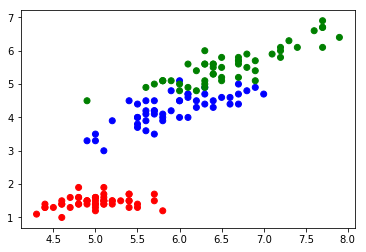

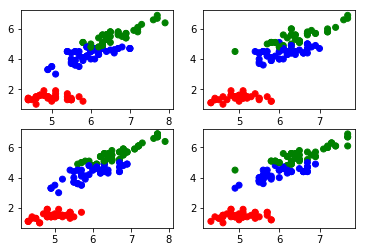

In [3]:
twoDimScatterPlot(X, y)
plt.show()

for idx in range(4):
    plt.subplot(2, 2, idx + 1)
    bootstrapX, bootstrapy = bootstrapSample(X, y)
    twoDimScatterPlot(bootstrapX, bootstrapy)
plt.show()

# 2 Bootstrap sampling application: Bagging

Below is a class implementation of the bagging meta algorithm. It stores a list of *n* trained learners of a specified classifier type after the method trainLearners is called. The trainLearners method takes data, labels and a number of learners. Training is handled by the fit() function of sklearn. Note that the bootstrapSample method is virtually the same as the bootstrapFunction function shown above. After training is done, the ensemble can be used to make predictions for a test set of new data point using the method makePrediction. For each individual new point, the method vote is called, which tallies the predictions of the individual learners and returns the label with the largest count.

In [4]:
class BaggingEnsemble:
    
    def __init__(self, clftype):
        self.clftype = clftype
        self.learners = []
        
    def bootstrapSample(self):
        bootstrappedData = []
        bootstrappedLabels = []
        for i in range(len(self.data)):
            x = random.randint(0, len(self.data) - 1)
            bootstrappedData.append(self.data[x])
            bootstrappedLabels.append(self.labels[x])
        return np.array(bootstrappedData), np.array(bootstrappedLabels)
        
    def trainLearners(self, data, labels, nrLearners):
        self.data = np.array(data)
        self.labels = labels
        self.learners = []
        for i in range(nrLearners):
            bootstrappedData, bootstrappedLabels = self.bootstrapSample()
            clf = self.clftype.fit(bootstrappedData, bootstrappedLabels)
            self.learners.append(clf)
    
    def vote(self, point):
        predictions = []
        for clf in self.learners:
            newPrediction = clf.predict(point.reshape(1, -1))
            if newPrediction < len(predictions):
                predictions[newPrediction] += 1
            else:
                predictions.append(1)
        return predictions.index(max(predictions))
    
    def makePrediction(self, testSet):
        if self.learners == []: return "Ensemble needs to be trained first"
        ypredict = []
        for point in testSet:
            ypredict.append(self.vote(point))
        return np.array(ypredict)

# 3 Single decision tree vs. bagging trees ensemble

The code block below generates a plot of the class boundaries for a single decision tree trained on the loaded data, as well as the class boundaries for an ensemble of five trees trained on a bootstrap sample of it. The background colors give the class boundaries, the training data is plotted as a scatter plot on top of this for clarity. We can see that that the class boundaries for the single decision tree are highly specific and feel counterintuitive, where as the class boundaries are smoother for the bagging ensemble. This corresponds to property of bagging ensembles to decrease the effect of outliers and prevent overfitting to training data.

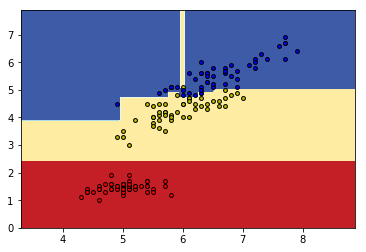

D:\Programs\Anaconda2\lib\site-packages\ipykernel\__main__.py:30: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


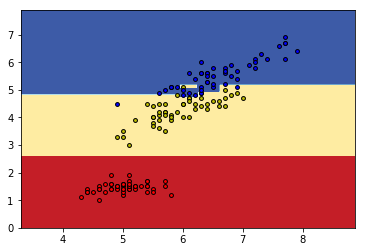

In [5]:
# Decision tree plot example from: http://scikit-learn.org/stable/auto_examples/tree/plot_iris.html#sphx-glr-auto-examples-tree-plot-iris-py
n_classes = 3
plot_colors = "ryb"
plot_step = 0.02

# Train a single decision tree and a bagging ensemble of five trees
clf = DecisionTreeClassifier().fit(X, y)
fiveTreesEnsemble = BaggingEnsemble(DecisionTreeClassifier())
fiveTreesEnsemble.trainLearners(X, y, 10)

# Generate plots
for idx in [1, 2]:
    # Plot the decision boundary
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))    
    if idx == 1:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    elif idx == 2:
        Z = fiveTreesEnsemble.makePrediction(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, label=iris.target_names[i],
                    cmap=plt.cm.RdYlBu, edgecolor='black', s=15)
    plt.axis("tight")
    plt.show()    


# Challenge: Test the effectiveness of bagging ensembles for yourself

In the code block below, two more functions are given. Using these functions and the rest of the code given in the tutorial up to this point, to test the difference between a single classifier and an ensemble of classifiers on the accuracy of a test set, after training on a different training set. You can copy the code to train a single decision tree classifier and a bagging ensemble of decision trees from section 3 or use a different type of classifier provided by python's sklearn library. Also try experimenting with different numbers of trees in the ensemble.

In [6]:
# split train and test data
def splitTrainTest(X, y):
    Xtrain = []
    ytrain = []
    ytrainCols = []
    Xtest = []
    ytest = []
    ytestCols = []
    for p in range(len(X)):
        chance = random.random()
        if chance > 0.8:
            Xtest.append(X[p])
            ytest.append(y[p])
            ytestCols.append(giveColor(y[p]))
        else:
            Xtrain.append(X[p])
            ytrain.append(y[p])
            ytrainCols.append(giveColor(y[p]))
    Xtrain = np.array(Xtrain)
    ytrain = np.array(ytrain)
    ytrainCols = np.array(ytrainCols)
    Xtest = np.array(Xtest)
    ytest = np.array(ytest)
    ytestCols = np.array(ytestCols)
    return Xtrain, ytrain, ytrainCols, Xtest, ytest, ytestCols

# calculate accuracy of prediction labels compared to ground truth validation labels
def calcAccuracy(ytest, ypredict):
    acc = 0.0
    for i in range(len(ytest)):
        if ytest[i] == ypredict[i]:
            acc += 1.0/len(ytest)
    return acc
